# Data loading

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
allSRS_pickle_dir='/home/jovyan/efs/all_seq/meta_data/allSRS.with_processed_data.pickle.gz'
%time allSRS=pd.read_pickle(allSRS_pickle_dir)

CPU times: user 5.15 s, sys: 436 ms, total: 5.58 s
Wall time: 5.59 s


In [3]:
allSRS.index.names=['SRS','Attrib']

### load in technical metadata

In [4]:
sra_dump_pickle_dir='/home/jovyan/efs/all_seq/meta_data/sra_dump.fastqc.bowtie_algn.pickle'
%time technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

CPU times: user 4.21 s, sys: 1.46 s, total: 5.67 s
Wall time: 5.67 s


In [5]:
technical_meta_data_df[('SRAmeta','Run')]=technical_meta_data_df.index

# Find the relevent SRS (Sample  IDs)  


In [6]:
#querySpecie='Mus musculus'
#label to regex for extracting the data
queryLabelToRegexDict={"B-Cell":'B-Cell|B-Lymphocyte',"T-Lymphocyte":'T-Lymphocyte|T-Cell'}

In [7]:
myL=[]
for  queryRegex in queryLabelToRegexDict.values():
    %time hitSrsS=allSRS[allSRS.str.contains(queryRegex,case=False)]
    myL.append(hitSrsS)

CPU times: user 4.26 s, sys: 148 ms, total: 4.41 s
Wall time: 3.83 s
CPU times: user 4.24 s, sys: 56 ms, total: 4.3 s
Wall time: 3.7 s


In [8]:
queryLabel='queryLabel'
mergeS=pd.concat(myL,keys=queryLabelToRegexDict.keys(),names=[queryLabel])

In [9]:
#mergeS.groupby(tmpLabel).size()

In [10]:
mergeS_noDup=mergeS.groupby(['SRS','queryLabel','Attrib']).first()

In [11]:
unqiueHitMask=mergeS_noDup.groupby('SRS').size()==1
unqiueHitSrs=unqiueHitMask.index[unqiueHitMask]

In [12]:
mergeS_noDup_unique=mergeS_noDup[mergeS_noDup.index.get_level_values('SRS').isin(unqiueHitSrs)]

Number of SRS per query class

In [13]:
mergeS_noDup_unique.groupby(queryLabel).size()

queryLabel
B-Cell          1105
T-Lymphocyte    1060
dtype: int64

In [14]:
srsToClasses_all=mergeS_noDup_unique.reset_index().set_index(['SRS'])['queryLabel']

sample the metadata 

In [15]:
srsToClasses=srsToClasses_all

In [16]:
srsToClasses.sample(n=10)

SRS
SRS349257           B-Cell
SRS2102601          B-Cell
SRS261391           B-Cell
SRS000061           B-Cell
SRS378682     T-Lymphocyte
ERS1505431    T-Lymphocyte
SRS348815     T-Lymphocyte
SRS1129766          B-Cell
SRS1161453          B-Cell
SRS1464359    T-Lymphocyte
Name: queryLabel, dtype: object

### map to SRR SRA

In [17]:
m_SRAMeta=technical_meta_data_df[('SRAmeta','Sample')].isin(srsToClasses.index)
technical_meta_data_df_hit=technical_meta_data_df[m_SRAMeta]

In [18]:
SRAMetasrsCorrespondingQuery=srsToClasses.loc[technical_meta_data_df_hit[('SRAmeta','Sample')]].values
technical_meta_data_df_hit[('SRAmeta',queryLabel)]=SRAMetasrsCorrespondingQuery

/opt/conda/envs/skymap/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
relevantMetaColsL=[('SRAmeta',queryLabel),('SRAmeta','Study'),('SRAmeta','Sample'),('SRAmeta','Run'),('SRAmeta','ScientificName')]
technical_meta_data_df_sub=technical_meta_data_df_hit[relevantMetaColsL]#[('SRAmeta',queryLabel)]

In [20]:
designDf=technical_meta_data_df_sub['SRAmeta']
#multI=designDf.set_index(designDf.columns.tolist())

Top specie with data

In [21]:
designDf['ScientificName'].value_counts().head(n=5)

Homo_sapiens                      17564
Mus_musculus                        203
Geobacter_sulfurreducens_KN400        0
Geodermatophilus_aquaeductus          0
Geodermatophilus_amargosae            0
Name: ScientificName, dtype: int64

In [22]:
querySpecie='Homo_sapiens'

In [23]:
def loadDf(fname,mmap_mode='r'):
    with open(fname+'.index.txt') as f:
        myIndex=map(lambda s:s.replace("\n",""), f.readlines())
    with open(fname+'.columns.txt') as f:
        myColumns=map(lambda s:s.replace("\n",""), f.readlines())
    tmpMatrix=np.load(fname+".npy",mmap_mode=mmap_mode)
    tmpDf=pd.DataFrame(tmpMatrix,index=myIndex,columns=myColumns)
    tmpDf.columns.name='Run'
    return tmpDf
baseDir='/home/jovyan/efs/all_seq/rnaseq_merged/' #Base directory
expression_metric='tpm' #offer Kallisto expression metric: ["tpm","est_counts"]
 #Check files in baseDir directory for more species
data_matrix_dir=baseDir+'/{specie}.gene_symbol.{expression_metric}'.format(specie=querySpecie,
                                            expression_metric=expression_metric)

%time rnaseqDf=loadDf(data_matrix_dir)

CPU times: user 144 ms, sys: 4 ms, total: 148 ms
Wall time: 167 ms


In [24]:
%time designDf_specie=designDf[(designDf['ScientificName']==querySpecie)&(designDf.Run.isin(rnaseqDf.columns))]

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 51.9 ms


In [25]:
designDf_specie.groupby(queryLabel).size()

queryLabel
B-Cell          459
T-Lymphocyte    904
dtype: int64

In [26]:
#3.2G 
designDf_subsampled=designDf_specie.sample(n=designDf_specie.shape[0]).groupby(queryLabel).head(n=2)

In [27]:
queryDesignDf=designDf_specie

### loading the expression matrix

In [28]:
designDf_subsampled.head()

,queryLabel,Study,Sample,Run,ScientificName
ERR1797347,T-Lymphocyte,ERP020994,ERS1505447,ERR1797347,Homo_sapiens
SRR2225461,B-Cell,SRP062950,SRS1047417,SRR2225461,Homo_sapiens
SRR519910,B-Cell,SRP014174,SRS349345,SRR519910,Homo_sapiens
ERR1797455,T-Lymphocyte,ERP020994,ERS1505474,ERR1797455,Homo_sapiens


In [29]:
%time hitDf=pd.DataFrame( list(map( lambda srrId: rnaseqDf[srrId],queryDesignDf.Run))).T

CPU times: user 984 ms, sys: 104 ms, total: 1.09 s
Wall time: 1.09 s


In [92]:
hitDf.columns=queryDesignDf.set_index(queryDesignDf.columns.tolist()).index

In [182]:
float16=2**6
hitDf.as_matrix()[hitDf.as_matrix()==inf]=float16

/opt/conda/envs/skymap/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


#  Example Analysis


In [183]:
inputAnalyzeDf=np.log2(hitDf+1)


### PCA to show samples are grouped in the higher dimensional space

In [184]:
inPcaDf=inputAnalyzeDf.T

In [185]:
from sklearn import decomposition
from numpy import inf


In [186]:
PCA=decomposition.PCA(n_components=3)

In [187]:
pcaM=PCA.fit_transform((inPcaDf))

In [188]:
inPcaDf.head()

TRDD2  TRDD1  \
queryLabel Study     Sample     Run        ScientificName                 
B-Cell     SRP015715 SRS362251  SRR567561  Homo_sapiens      0.0    0.0   
                     SRS362252  SRR567562  Homo_sapiens      0.0    0.0   
           SRP045500 SRS684342  SRR1551103 Homo_sapiens      0.0    0.0   
                     SRS684323  SRR1551084 Homo_sapiens      0.0    0.0   
           SRP077016 SRS1523416 SRR3714038 Homo_sapiens      0.0    0.0   

                                                           TRDD3  IGHD4-17  \
queryLabel Study     Sample     Run        ScientificName                    
B-Cell     SRP015715 SRS362251  SRR567561  Homo_sapiens      0.0       0.0   
                     SRS362252  SRR567562  Homo_sapiens      0.0       0.0   
           SRP045500 SRS684342  SRR1551103 Homo_sapiens      0.0       0.0   
                     SRS684323  SRR1551084 Homo_sapiens      0.0       0.0   
           SRP077016 SRS1523416 SRR3714038 Homo_sapiens      0.0       0.0   

                                                           IGHD4-4  IGHD2-15  \
queryLabel Study     Sample     Run        ScientificName                      
B-Cell     SRP015715 SRS362251  SRR567561  Homo_sapiens        0.0   0.00000   
                     SRS362252  SRR567562  Homo_sapiens        0.0   0.00000   
           SRP045500 SRS684342  SRR1551103 Homo_sapiens        0.0   5.31250   
                     SRS684323  SRR1551084 Homo_sapiens        0.0   2.28125   
           SRP077016 SRS1523416 SRR3714038 Homo_sapiens        0.0   4.40625   

                                                           IGHD3-22  IGHD3-16  \
queryLabel Study     Sample     Run        ScientificName                       
B-Cell     SRP015715 SRS362251  SRR567561  Homo_sapiens    0.000000  0.000000   
                     SRS362252  SRR567562  Homo_sapiens    0.000000  0.000000   
           SRP045500 SRS684342  SRR1551103 Homo_sapiens    0.000000  2.242188   
                     SRS684323  SRR1551084 Homo_sapiens    1.550781  4.800781   
           SRP077016 SRS1523416 SRR3714038 Homo_sapiens    4.406250  4.656250   

                                                           IGHD5-18  IGHD6-25  \
queryLabel Study     Sample     Run        ScientificName                       
B-Cell     SRP015715 SRS362251  SRR567561  Homo_sapiens         0.0       0.0   
                     SRS362252  SRR567562  Homo_sapiens         0.0       0.0   
           SRP045500 SRS684342  SRR1551103 Homo_sapiens         0.0       0.0   
                     SRS684323  SRR1551084 Homo_sapiens         0.0       0.0   
           SRP077016 SRS1523416 SRR3714038 Homo_sapiens         0.0       0.0   

                                                              ...      \
queryLabel Study     Sample     Run        ScientificName     ...       
B-Cell     SRP015715 SRS362251  SRR567561  Homo_sapiens       ...       
                     SRS362252  SRR567562  Homo_sapiens       ...       
           SRP045500 SRS684342  SRR1551103 Homo_sapiens       ...       
                     SRS684323  SRR1551084 Homo_sapiens       ...       
           SRP077016 SRS1523416 SRR3714038 Homo_sapiens       ...       

                                                           AC108729.3  \
queryLabel Study     Sample     Run        ScientificName               
B-Cell     SRP015715 SRS362251  SRR567561  Homo_sapiens           0.0   
                     SRS362252  SRR567562  Homo_sapiens           0.0   
           SRP045500 SRS684342  SRR1551103 Homo_sapiens           0.0   
                     SRS684323  SRR1551084 Homo_sapiens           0.0   
           SRP077016 SRS1523416 SRR3714038 Homo_sapiens           0.0   

                                                           AC025588.4  \
queryLabel Study     Sample     Run        ScientificName               
B-Cell     SRP015715 SRS362251  SRR567561  Homo_sapiens           0.0   
                     SRS362252  SRR567562  Hom

In [189]:
pcaDf=pd.DataFrame( data=pcaM,index=inPcaDf.index)

In [190]:
%matplotlib inline
import seaborn as sns

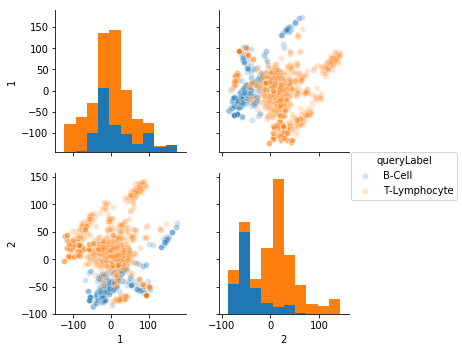

In [191]:
plotPcs=[1,2]
sns.pairplot(data=pcaDf.reset_index()[plotPcs+[queryLabel]],hue=queryLabel,plot_kws={'alpha':0.2})

### Volcano plot with t-test

/opt/conda/envs/skymap/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/skymap/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/envs/skymap/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/envs/skymap/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/envs/skymap/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


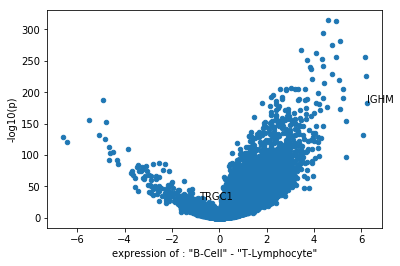

In [192]:
labelA='B-Cell'
labelB='T-Lymphocyte'
annotateGenes=['TRGC1','IGHM']

t,p=stats.ttest_ind(inputAnalyzeDf[labelA],inputAnalyzeDf[labelB],axis=1)

effectDiff=inputAnalyzeDf[labelA].mean(axis=1)-inputAnalyzeDf[labelB].mean(axis=1)

effectLabel='expression of : "{}" - "{}"'.format(labelA, labelB)
tmpDf=pd.DataFrame({'t':t,'-log10(p)':-np.log10(p),effectLabel:effectDiff,'u':inputAnalyzeDf.mean(axis=1)},index=inputAnalyzeDf.index)
#log2DataAverageMin=0.0
plotDf=tmpDf[tmpDf['u']>=0]
yLabel='-log10(p)'
xLabel=effectLabel
ax=plotDf.plot(x=xLabel,y=yLabel,kind='Scatter')

annotDf=plotDf.loc[annotateGenes]

for geneName, tmpS in annotDf.iterrows():
    ax.annotate(xy=(tmpS.loc[xLabel],tmpS.loc[yLabel]),text=geneName)
    

In [193]:
rankS=tmpDf['-log10(p)'].fillna(1.0).sort_values().rank()/tmpDf.shape[0]

In [194]:
queryGene='IGHM'
upRegDf=tmpDf[tmpDf[effectLabel]>0]
rankOfGene=(upRegDf['-log10(p)'].rank()/upRegDf.shape[0]).loc[queryGene]
print ('% rank of {} -log10(p) among up regulated genes:'.format(queryGene),rankOfGene)

% rank of IGHM -log10(p) among up regulated genes: 0.9981815820236394


In [195]:
queryGene='TRGC1'
downRegDf=tmpDf[tmpDf[effectLabel]<0]
rankOfGene=(downRegDf['-log10(p)'].rank()/downRegDf.shape[0]).loc[queryGene]
print ('% rank of {} -log10(p) among downregulated genes:'.format(queryGene),rankOfGene)

% rank of TRGC1 -log10(p) among downregulated genes: 0.9869343255170027


### Study correlation heatmap

In [196]:
sigDf=inputAnalyzeDf.groupby(level=['queryLabel','Study'],axis=1).mean()

In [252]:
#sigDf.isnull().any().any()

In [248]:
corrDf=sigDf[sigDf.mad(axis=1)>np.log2(4+1)].corr()

In [249]:
corrDf_valid=corrDf.loc[~corrDf.isnull().all(axis=1),~corrDf.isnull().all(axis=0)]

In [250]:
myColorL=['red','green','blue']
labelToColorS=pd.Series(dict(zip(corrDf_valid.index.get_level_values('queryLabel').unique(),myColorL)))
labelToColorS

B-Cell            red
T-Lymphocyte    green
dtype: object

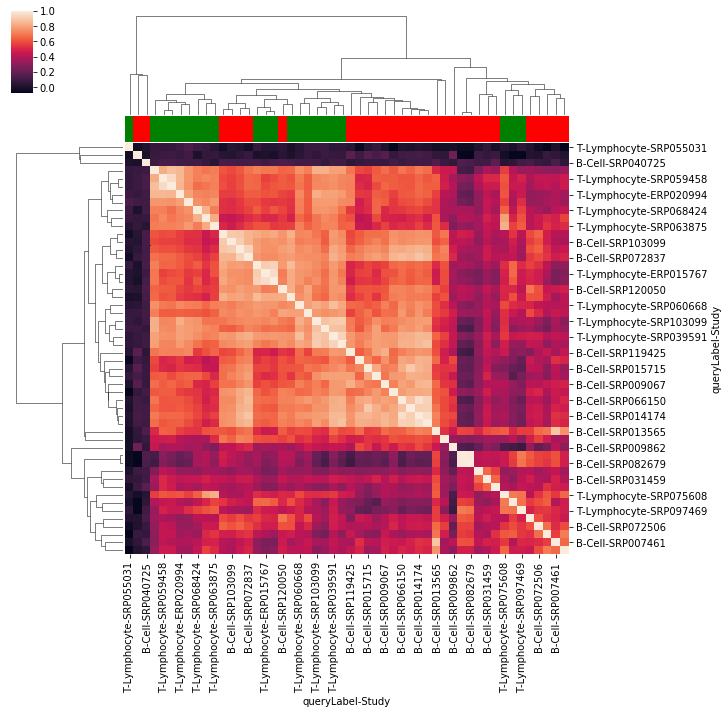

In [255]:
colors=labelToColorS[corrDf_valid.index.get_level_values('queryLabel')].values
g=sns.clustermap(data=corrDf_valid,col_colors=colors,metric='euclidean')
g

# Caveats

### Caveat: the mode of expression from public sequencing data usually don't have same center

You might want to do a median/mean center in your dataset

In [200]:
inputAnalyzeDf[labelA].mean(axis=1).median(),\
inputAnalyzeDf[labelB].mean(axis=1).median()

(0.3562, 0.2487)

### Caveat: Batch effect
If the first PC (PC0 in the following plot) does not seperate the  experimental condition, this is most likely due to batch effect. Sometimes plotting second and third PC like the above plot will find the seperation.

If it doesn't do the job, I recommend doing a simple z-score of the data before going down the route of using batch correction tools like: [Combat, SVR](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0030161) or DEseq. 

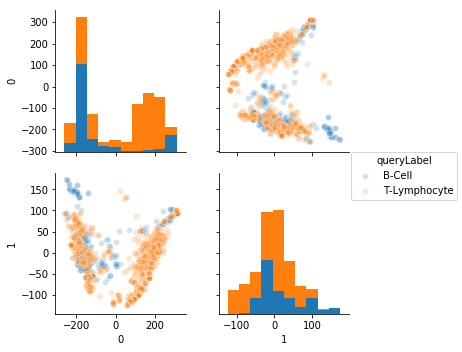

In [164]:
plotPcs=[0,1]
sns.pairplot(data=pcaDf.reset_index()[plotPcs+[queryLabel]],hue=queryLabel,plot_kws={'alpha':0.2})